In [179]:
import matplotlib
import xarray as xr
import seaborn as sns
import datashader as ds
from datashader import transfer_functions as tf

In [2]:
dset = xr.load_dataset('../../steinmetz_analysis/data/steinmetz_2017-01-11_Radnitz.nc')
dset

<xarray.Dataset>
Dimensions:             (trial: 252, time: 250, cell: 549,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 11, spike_id: 2365035)
Coordinates:
  * trial               (trial) int32 1 2 3 4 5 6 7 ... 247 248 249 250 251 252
  * time                (time) float64 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 1 2 3 4 5 6 7 ... 544 545 546 547 548 549
  * waveform_component  (waveform_component) int32 1 2 3
  * probe               (probe) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) object 'MRN' 'RSP' ... 'POL' 'RSP'
  * spike_id            (spike_id) int32 1 2 3 4 ... 2365033 2365034 2365035
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 0 0 0 0 0 0 100 0 ... 0 100 0 0 100 100 0
    contrast_right      (trial) int8 100 50 0 100 0 50 ... 50 50 100 25 100 100
    gocue               (trial) float64 0.7544 1.186 0.8188 ... nan nan nan
    stim_onset          (trial) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan
    feedback_time       (trial) float64 1.272 1.668 2.358 1.836 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 0.0 ... 0....
    waveform_u          (cell, waveform_component, probe) float32 0.0 ... 0.0
    lfp                 (brain_area_lfp, trial, time) float64 8.479 ... 14.26
    spike_time          (spike_id) float32 0.9774 1.01 2.06 ... 1.121 1.143
    spike_cell          (spike_id) uint32 1 1 1 1 1 1 ... 549 549 549 549 549
    spike_trial         (spike_id) uint32 1 1 1 1 1 7 ... 243 247 247 249 249
Attributes:
    session_date:  2017-01-11
    mouse:         Radnitz
    stim_onset:    0.5
    bin_size:      0.01

In [49]:
dd = dset['waveform_w'].sel(drop=True)
dd.nbytes


540216

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


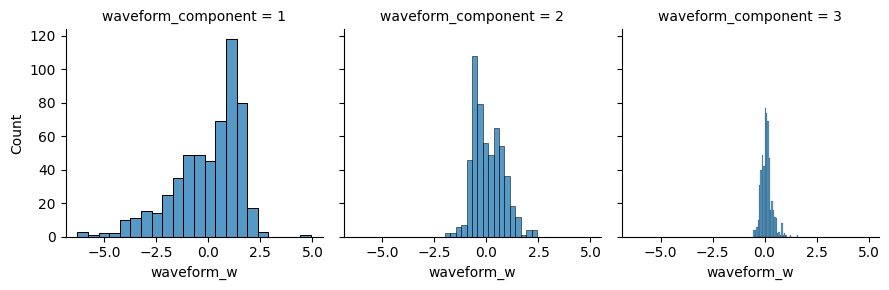

In [62]:
df = dd.sel(sample=45, drop=True).to_dataframe().reset_index()
g = sns.FacetGrid(data=df, col="waveform_component")
g.map_dataframe(sns.histplot, x="waveform_w");

c:\Users\delgr\anaconda3\envs\datascience1\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


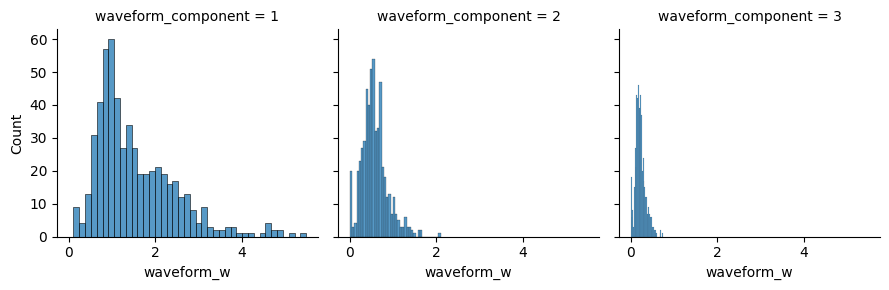

In [68]:
df = dd.sel(sample=slice(35, 50)).std(dim='sample').to_dataframe().reset_index()
g = sns.FacetGrid(data=df, col="waveform_component")
g.map_dataframe(sns.histplot, x="waveform_w", bins=40);

In [74]:
df = dd.sel(sample=slice(35, 50)).std(dim='sample').to_dataframe().unstack()['waveform_w']
df.head()

waveform_component,1,2,3
cell,,,
1,1.117418,0.608831,0.120255
2,0.908465,0.509327,0.170873
3,3.494085,1.232587,0.445793
4,1.862801,0.399044,0.262472
5,1.452797,0.338980,0.139970


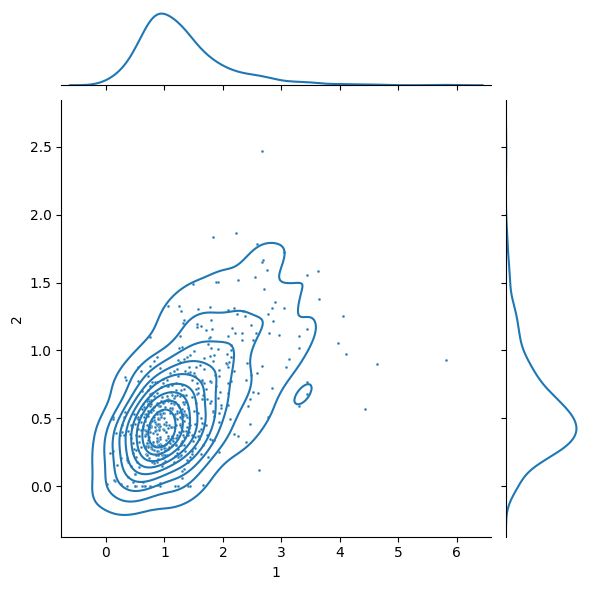

In [89]:
df = dd.sel(sample=slice(35, 45)).std(dim='sample').to_dataframe().unstack()['waveform_w']
sns.jointplot(data=df, x=1, y=2, kind='kde');
sns.scatterplot(data=df, x=1, y=2, s=4.);

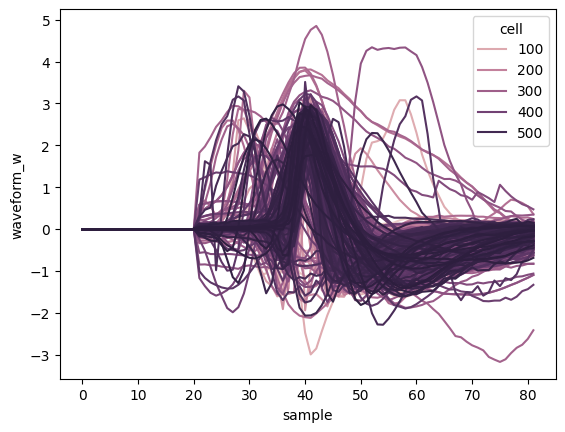

In [116]:
dd_normed = dd / dd.sel(sample=slice(30, 50)).std(dim='sample')
df = dd_normed.to_dataframe().reset_index()
df['waveform_component']
mask = (df['waveform_component'] == 1) #& ((500 <= df['cell']) & (df['cell'] < 800))
sns.lineplot(data=df[mask], x='sample', y='waveform_w', estimator=None, hue='cell');

In [142]:
mask = (df['waveform_component'] == 1) & (df['cell'].between(0, 50)) & (df['sample'].between(30, 50))
(df[mask].pivot(index='cell', columns='sample', values='waveform_w') * 100).astype(int).style.background_gradient()

sample,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
cell,,,,,,,,,,,,,,,,,,,,,
1,4,6,5,6,4,2,29,79,136,200,231,181,103,27,-25,-57,-82,-101,-114,-120,-117
2,2,4,4,5,7,10,14,33,94,210,287,277,236,190,141,97,59,25,-1,-22,-38
3,5,7,8,9,10,11,16,30,102,186,206,178,152,115,37,-70,-117,-121,-112,-98,-86
4,-1,0,0,-1,-6,-9,-22,-69,-97,150,245,207,106,-14,-87,-116,-112,-90,-63,-41,-25
5,3,2,3,4,3,5,7,27,104,190,243,242,185,112,48,-5,-43,-70,-86,-96,-101
6,0,0,0,0,1,-3,-1,17,88,195,256,270,256,231,198,165,133,100,72,48,23
7,0,-1,-1,1,1,5,3,11,52,147,232,263,264,247,216,182,139,102,68,38,11
8,9,8,9,13,20,40,82,137,204,256,273,263,242,212,173,130,85,46,10,-22,-53
9,-4,-5,-8,-13,-20,-31,-52,-72,-82,-33,132,257,211,96,-16,-81,-106,-109,-95,-76,-55


In [145]:
df[mask].set_index('sample')

,cell,waveform_component,waveform_w
sample,,,
0,1,1,0.000000
1,1,1,0.000000
2,1,1,0.000000
3,1,1,0.000000
4,1,1,0.000000
...,...,...,...
77,50,1,-0.022359
78,50,1,-0.023140
79,50,1,-0.017611


In [146]:
canvas.line?

Signature:
canvas.line(
    source,
    x=None,
    y=None,
    agg=None,
    axis=0,
    geometry=None,
    line_width=0,
    antialias=False,
)
Docstring:
Compute a reduction by pixel, mapping data to pixels as one or
more lines.

For aggregates that take in extra fields, the interpolated bins will
receive the fields from the previous point. In pseudocode:

>>> for i in range(len(rows) - 1):    # doctest: +SKIP
...     row0 = rows[i]
...     row1 = rows[i + 1]
...     for xi, yi in interpolate(row0.x, row0.y, row1.x, row1.y):
...         add_to_aggregate(xi, yi, row0)

Parameters
----------
source : pandas.DataFrame, dask.DataFrame, or xarray.DataArray/Dataset
    The input datasource.
x, y : str or number or list or tuple or np.ndarray
    Specification of the x and y coordinates of each vertex
    * str or number: Column labels in source
    * list or tuple: List or tuple of column labels in source
    * np.ndarray: When axis=1, a literal array of the
      coordinates to be used f

cell,1,2
sample,,
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
77,0.100331,-0.322780
78,0.113431,-0.279816
79,0.109695,-0.242856


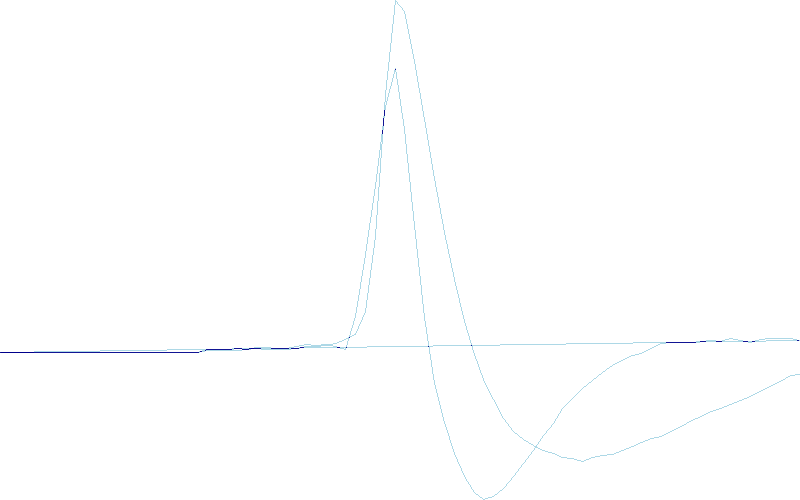

In [164]:
canvas = ds.Canvas(plot_width=800, plot_height=500)
mask = (df['waveform_component'] == 1) & df['cell'].between(1, 2)
agg = canvas.line(df[mask], 'sample', 'waveform_w', agg=ds.count(), antialias=False)
img = tf.shade(agg,  how='eq_hist')
img = tf.set_background(img, "white")
img

In [170]:
canvas.line?

Signature:
canvas.line(
    source,
    x=None,
    y=None,
    agg=None,
    axis=0,
    geometry=None,
    line_width=0,
    antialias=False,
)
Docstring:
Compute a reduction by pixel, mapping data to pixels as one or
more lines.

For aggregates that take in extra fields, the interpolated bins will
receive the fields from the previous point. In pseudocode:

>>> for i in range(len(rows) - 1):    # doctest: +SKIP
...     row0 = rows[i]
...     row1 = rows[i + 1]
...     for xi, yi in interpolate(row0.x, row0.y, row1.x, row1.y):
...         add_to_aggregate(xi, yi, row0)

Parameters
----------
source : pandas.DataFrame, dask.DataFrame, or xarray.DataArray/Dataset
    The input datasource.
x, y : str or number or list or tuple or np.ndarray
    Specification of the x and y coordinates of each vertex
    * str or number: Column labels in source
    * list or tuple: List or tuple of column labels in source
    * np.ndarray: When axis=1, a literal array of the
      coordinates to be used f

In [183]:

mask = (df['waveform_component'] == 1) & df['cell'].between(0, 2000)
df[mask].pivot(index='sample', columns='cell', values='waveform_w').reset_index()

cell,sample,1,2,3,4,5,6,7,8,9,...,540,541,542,543,544,545,546,547,548,549
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,77,0.100331,-0.322780,-0.019962,0.064780,0.062217,-0.631105,-0.383228,-0.155613,0.055970,...,-0.810756,-0.392632,0.056723,-0.071895,0.055656,-0.347047,-0.121210,-0.294657,-0.147512,-0.585566
78,78,0.113431,-0.279816,-0.022878,0.066057,0.062209,-0.618749,-0.337898,-0.100943,0.045693,...,-0.800485,-0.388725,0.070227,-0.048483,0.073125,-0.328873,-0.088848,-0.262501,-0.100999,-0.545768
79,79,0.109695,-0.242856,-0.010992,0.043243,0.050719,-0.585164,-0.292620,-0.069845,0.063625,...,-0.790872,-0.329017,0.080656,-0.040168,0.075698,-0.313942,-0.067649,-0.206103,-0.081325,-0.493762
80,80,0.109972,-0.194273,-0.004188,0.023047,0.057559,-0.534280,-0.242121,-0.034386,0.059445,...,-0.749502,-0.291033,0.068170,-0.032310,0.076436,-0.300702,-0.045931,-0.188787,-0.046120,-0.432577


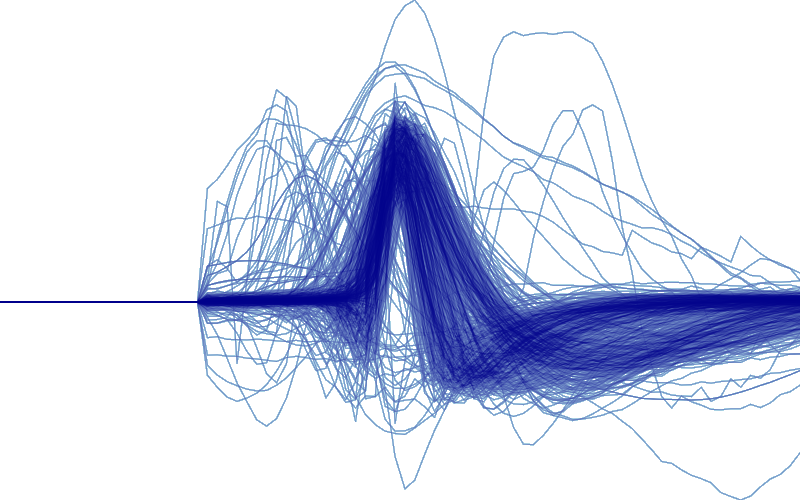

In [184]:
canvas = ds.Canvas(plot_width=800, plot_height=500)

mask = (df['waveform_component'] == 1) & df['cell'].between(0, 2000)
aa = df[mask].pivot(index='sample', columns='cell', values='waveform_w').reset_index()
agg = canvas.line(aa, x='sample', y=aa.columns[1:].tolist(), agg=ds.count(), antialias=True, axis=0)
img = tf.shade(agg,  how='eq_hist')
img = tf.set_background(img, "white")
img


In [192]:
tf.shade?

Signature:
tf.shade(
    agg,
    cmap=['lightblue', 'darkblue'],
    color_key=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62', '#8da0cb', '#a6d854', '#ffd92f', '#e5c494', '#ffffb3', '#fb8072', '#fdb462', '#fccde5', '#d9d9d9', '#ccebc5', '#ffed6f'],
    how='eq_hist',
    alpha=255,
    min_alpha=40,
    span=None,
    name=None,
    color_baseline=None,
    rescale_discrete_levels=False,
)
Docstring:
Convert a DataArray to an image by choosing an RGBA pixel color for each value.

Requires a DataArray with a single data dimension, here called the
"value", indexed using either 2D or 3D coordinates.

For a DataArray with 2D coordinates, the RGB channels are computed
from the values by interpolated lookup into the given colormap
``cmap``.  The A channel is then set to the given fixed ``alpha``
value for all non-zero values, and to zero for all zero values.
A dictionary ``color_key`` that specifies categories (values

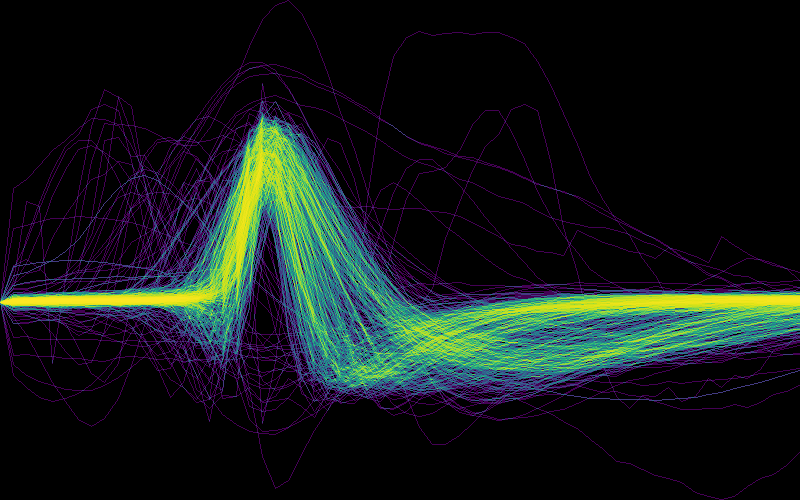

In [203]:
canvas = ds.Canvas(plot_width=800, plot_height=500)

mask = (df['waveform_component'] == 1) & df['cell'].between(0, 2000) & df['sample'].between(20, 100)
aa = df[mask].pivot(index='sample', columns='cell', values='waveform_w').reset_index()
agg = canvas.line(aa, x='sample', y=aa.columns[1:].tolist(), agg=ds.count(), antialias=False, axis=0)
img = tf.shade(agg, cmap=matplotlib.colormaps['viridis'], how='eq_hist')
img = tf.set_background(img, "black")
img


In [200]:
canvas.line?

Signature:
canvas.line(
    source,
    x=None,
    y=None,
    agg=None,
    axis=0,
    geometry=None,
    line_width=0,
    antialias=False,
)
Docstring:
Compute a reduction by pixel, mapping data to pixels as one or
more lines.

For aggregates that take in extra fields, the interpolated bins will
receive the fields from the previous point. In pseudocode:

>>> for i in range(len(rows) - 1):    # doctest: +SKIP
...     row0 = rows[i]
...     row1 = rows[i + 1]
...     for xi, yi in interpolate(row0.x, row0.y, row1.x, row1.y):
...         add_to_aggregate(xi, yi, row0)

Parameters
----------
source : pandas.DataFrame, dask.DataFrame, or xarray.DataArray/Dataset
    The input datasource.
x, y : str or number or list or tuple or np.ndarray
    Specification of the x and y coordinates of each vertex
    * str or number: Column labels in source
    * list or tuple: List or tuple of column labels in source
    * np.ndarray: When axis=1, a literal array of the
      coordinates to be used f

In [207]:
list(matplotlib.colormaps.keys())

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

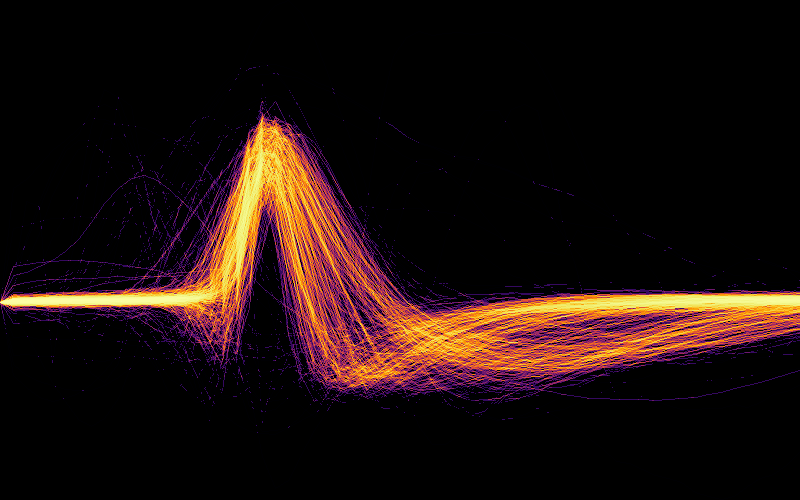

In [208]:
dfcanvas = ds.Canvas(plot_width=800, plot_height=500)

mask = (df['waveform_component'] == 1) & df['cell'].between(0, 2000) & df['sample'].between(20, 100)
aa = df[mask].pivot(index='sample', columns='cell', values='waveform_w').reset_index()
agg = canvas.line(aa, x='sample', y=aa.columns[1:].tolist(), agg=ds.count(), antialias=False, axis=0)
img = tf.shade(agg, cmap=matplotlib.colormaps['inferno'], how='eq_hist')
img = tf.set_background(img, "black")
img


## Aside: Let's see all the mice's waveforms!

In [242]:
from glob import glob
import pandas as pd

paths = glob('../../steinmetz_analysis/data/*.nc')
dds = []
cell_id = 0
for path in paths:
    dset = xr.load_dataset(path)
    dd = dset['waveform_w'].sel(waveform_component=1, sample=slice(20, 100), drop=True).to_dataframe().reset_index('cell')
    dd['cell'] += cell_id
    cell_id = dd['cell'].max()
    dds.append(dd.reset_index())
dff = pd.concat(dds, ignore_index=False)

In [243]:
dff

,sample,cell,waveform_w
0,0,1,0.000000
1,1,1,0.017568
2,2,1,0.051397
3,3,1,0.045022
4,4,1,0.045758
...,...,...,...
67513,57,33958,0.066342
67514,58,33958,0.065918
67515,59,33958,0.063466
67516,60,33958,0.065932


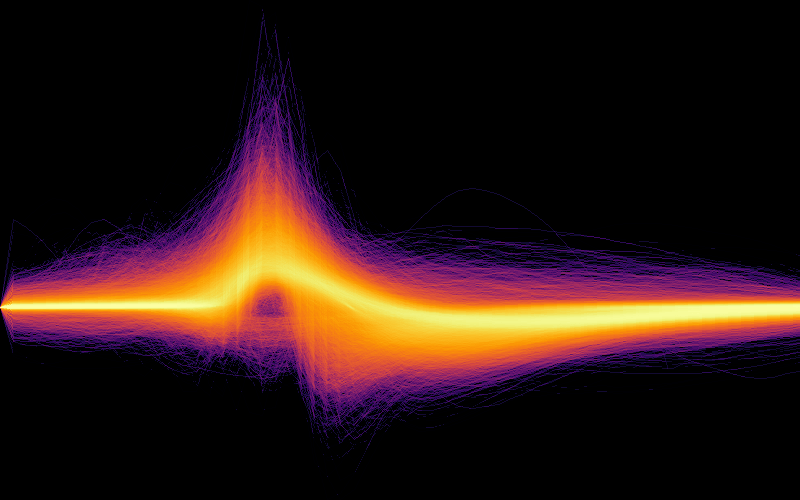

In [244]:
canvas = ds.Canvas(plot_width=800, plot_height=500)
aa = dff.pivot_table(index='sample', columns='cell', values='waveform_w').reset_index()
agg = canvas.line(aa, x='sample', y=aa.columns[1:].tolist(), agg=ds.count(), antialias=False, axis=0)
img = tf.shade(agg, cmap=matplotlib.colormaps['inferno'], how='eq_hist')
img = tf.set_background(img, "black")
img